In [ ]:
!ls /content/drive/MyDrive/InceptezFiles/COVID-19.zip

ls: cannot access '/content/drive/MyDrive/InceptezFiles/COVID-19.zip': No such file or directory


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/InceptezFiles/COVID-19.zip

Archive:  /content/drive/MyDrive/InceptezFiles/COVID-19.zip
  inflating: COVID-CT-MetaInfo.xlsx  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: CT_COVID/2020.01.24.919183-p27-132.png  
  inflating: CT_COVID/2020.01.24.919183-p27-133.png  
  inflating: CT_COVID/2020.01.24.919183-p27-134.png  
  inflating: CT_COVID/2020.01.24.919183-p27-135.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%0.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%1.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%10.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%11.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%12.png  
  inflating: CT_COVID/2020.02.10.20021584-p6-52%13.png  
  inflati

In [3]:
!pip install torchinfo

In [4]:
import os
import glob
import sklearn
from sklearn.model_selection import train_test_split
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import cv2

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
pos_files = glob.glob("CT_COVID/*.*")

In [9]:
neg_files = glob.glob("CT_NonCOVID/*.*")

In [10]:
images = pos_files+neg_files
labels = np.array([1] * len(pos_files)+[0]*len(neg_files))

In [11]:
images_tv, images_test,y_tv,y_test = train_test_split(images,labels,shuffle = True,test_size = 0.2,random_state=124)

In [12]:
images_train, images_val,y_train,y_val = train_test_split(images_tv,y_tv,shuffle = True,test_size = 0.25,random_state=124)

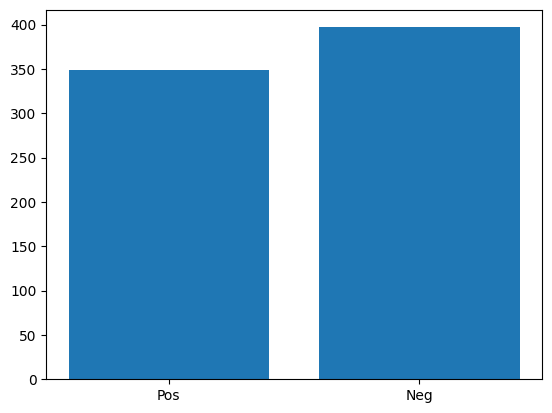

In [13]:
num_pos, num_neg = len(pos_files),len(neg_files)

plt.bar(['Pos','Neg'],[num_pos,num_neg])
plt.show()

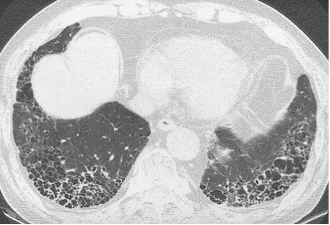

In [14]:
Image(images_train[6])

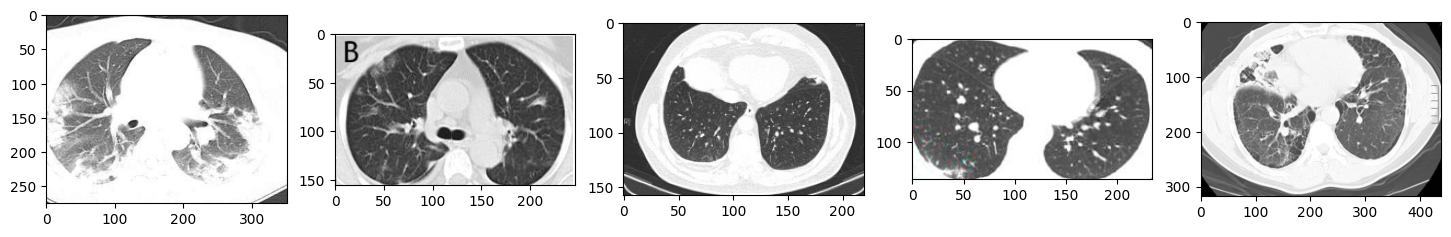

In [15]:
im = [cv2.imread(images_train[i]) for i in range(20,25)]

fig, ax = plt.subplots(ncols = 5,figsize=(18,5))
for i in range(len(im)):
  ax[i].imshow(im[i],cmap = 'gray')

plt.show()

In [16]:
im[0].shape

(275, 351, 3)

In [17]:
im[1].shape

(155, 247, 3)

In [18]:
im[2].shape

(158, 220, 3)

In [34]:
class CT_Dataset(Dataset):
  def __init__(self, img_path, img_labels, img_transforms=None,grayscale = True):
    self.img_path = img_path
    self.img_labels = torch.Tensor(img_labels)
    if (img_transforms is None) & (grayscale == True):
      self.transforms = transforms.Compose([transforms.Grayscale(),transforms.Resize([250,250]),transforms.ToTensor()])
    elif grayscale == False:
      self.transforms = transforms.Compose([transforms.Resize([250,250]),transforms.ToTensor()])
    else:
      self.transforms = img_transforms

  def __getitem__(self,index):
    cur_path = self.img_path[index]
    cur_img = PIL.Image.open(cur_path).convert("RGB")
    cur_img = self.transforms(cur_img)
    return cur_img, self.img_labels[index]

  def __len__(self):
    return len(self.img_path)

In [20]:
#define CNN Module
class Convnet(nn.Module):
  def __init__(self, dropout = 0.5):
    super(Convnet,self).__init__()
    #input = (num_batches,1,250,250)
    self.convnet = nn.Sequential(
        nn.Conv2d(in_channels = 1,out_channels = 64,kernel_size = 3,),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Flatten() #(num_batches,)
        )

    self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features = 12800,out_features = 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features = 512,out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256,out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128,out_features = 1),
        )
  def forward(self,x):
    x = self.convnet(x)
    x = self.classifier(x)
    return x

In [21]:
vision_model = Convnet()
summary(vision_model,(32,1,250,250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 12800]               --
│    └─Conv2d: 2-1                       [32, 64, 248, 248]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 248, 248]        128
│    └─ReLU: 2-3                         [32, 64, 248, 248]        --
│    └─MaxPool2d: 2-4                    [32, 64, 124, 124]        --
│    └─Conv2d: 2-5                       [32, 128, 122, 122]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 122, 122]       256
│    └─ReLU: 2-7                         [32, 128, 122, 122]       --
│    └─MaxPool2d: 2-8                    [32, 128, 61, 61]         --
│    └─Conv2d: 2-9                       [32, 256, 59, 59]         295,168
│    └─BatchNorm2d: 2-10                 [32, 256, 59, 59]         512
│    └─ReLU: 2-11                        [32, 256, 59, 59]         --
│ 

In [22]:
def train_model(model,train_dataset, val_dataset,device,lr=0.0001,epochs = 30, batch_size=32, gamma=0.5,l2=0.00001,patience = 1):
  model = model.to(device)
  train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle = True)
  #test_loader = DataLoader(test_dataset, batch_size = 1,shuffle =False)

  #history
  history = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = lr,weight_decay = l2)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = patience,gamma = gamma)

  print("Training Start:")
  for epoch in range(epochs):
    model.train() #Put the model into training mode
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc =0

    for i,(images,labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images).view(-1)
      pred = torch.sigmoid(outputs)
      pred = torch.round(pred)

      cur_training_loss = criterion(outputs,labels)
      cur_training_acc = (pred == labels).sum().item() / batch_size

      #back propagation
      cur_training_loss.backward()
      optimizer.step()

      optimizer.zero_grad()
      train_loss += cur_training_loss
      train_acc +=cur_training_acc

    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).view(-1)

        cur_valid_loss = criterion(outputs,labels)
        val_loss += cur_valid_loss

        pred = torch.sigmoid(outputs)
        pred = torch.round(pred)
        val_acc += (pred == labels).sum().item() / batch_size
        #cur_training_acc = (pred == labels).sum().item() / batch_size

    scheduler.step()

    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_acc = val_acc/len(val_loader)

    print("LR:", optimizer.param_groups[0]['lr'])
    print(f'Epoch: {epoch+1} / {epochs}, train_loss:{train_loss:.5f}, train_acc: {train_acc:.5f}, val_loss:{val_loss:.5f},valid_acc:{val_acc:.5f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

  return history

In [23]:
train_dataset = CT_Dataset(img_path= images_train, img_labels = y_train)
val_dataset = CT_Dataset(img_path= images_val, img_labels = y_val)

cnn_model = Convnet(dropout = 0.5)
hist = train_model(cnn_model,train_dataset,val_dataset,device, lr = 0.0002, batch_size = 32,epochs = 35, l2=0.09, patience = 3)

Training Start:
LR: 0.0002
Epoch: 1 / 35, train_loss:0.67880, train_acc: 0.55134, val_loss:0.69442,valid_acc:0.47500
LR: 0.0002
Epoch: 2 / 35, train_loss:0.60837, train_acc: 0.65625, val_loss:0.72115,valid_acc:0.47500
LR: 0.0001
Epoch: 3 / 35, train_loss:0.58668, train_acc: 0.69643, val_loss:0.72932,valid_acc:0.48125
LR: 0.0001
Epoch: 4 / 35, train_loss:0.54946, train_acc: 0.70759, val_loss:0.69126,valid_acc:0.54375
LR: 0.0001
Epoch: 5 / 35, train_loss:0.49389, train_acc: 0.75446, val_loss:0.58477,valid_acc:0.67500
LR: 5e-05
Epoch: 6 / 35, train_loss:0.44965, train_acc: 0.79018, val_loss:0.60086,valid_acc:0.62500
LR: 5e-05
Epoch: 7 / 35, train_loss:0.37558, train_acc: 0.84375, val_loss:0.66229,valid_acc:0.57500
LR: 5e-05
Epoch: 8 / 35, train_loss:0.31428, train_acc: 0.88393, val_loss:0.61427,valid_acc:0.62500
LR: 2.5e-05
Epoch: 9 / 35, train_loss:0.25770, train_acc: 0.91295, val_loss:0.49349,valid_acc:0.70625
LR: 2.5e-05
Epoch: 10 / 35, train_loss:0.16437, train_acc: 0.97321, val_loss:

In [24]:
trainloss = [i.detach().cpu().numpy() for i in hist['train_loss']]
valloss = [i.detach().cpu().numpy() for i in hist['val_loss']]

In [25]:
trainloss

[array(0.67880034, dtype=float32),
 array(0.6083707, dtype=float32),
 array(0.5866847, dtype=float32),
 array(0.54946226, dtype=float32),
 array(0.49388784, dtype=float32),
 array(0.44965246, dtype=float32),
 array(0.37558338, dtype=float32),
 array(0.31428298, dtype=float32),
 array(0.25770172, dtype=float32),
 array(0.16437498, dtype=float32),
 array(0.12890325, dtype=float32),
 array(0.10625717, dtype=float32),
 array(0.07163717, dtype=float32),
 array(0.05867187, dtype=float32),
 array(0.04464491, dtype=float32),
 array(0.04206227, dtype=float32),
 array(0.03553356, dtype=float32),
 array(0.0354273, dtype=float32),
 array(0.03293361, dtype=float32),
 array(0.03316329, dtype=float32),
 array(0.02793403, dtype=float32),
 array(0.02845869, dtype=float32),
 array(0.02988266, dtype=float32),
 array(0.02875093, dtype=float32),
 array(0.02839485, dtype=float32),
 array(0.02829641, dtype=float32),
 array(0.02944528, dtype=float32),
 array(0.02901419, dtype=float32),
 array(0.02522059, dtyp

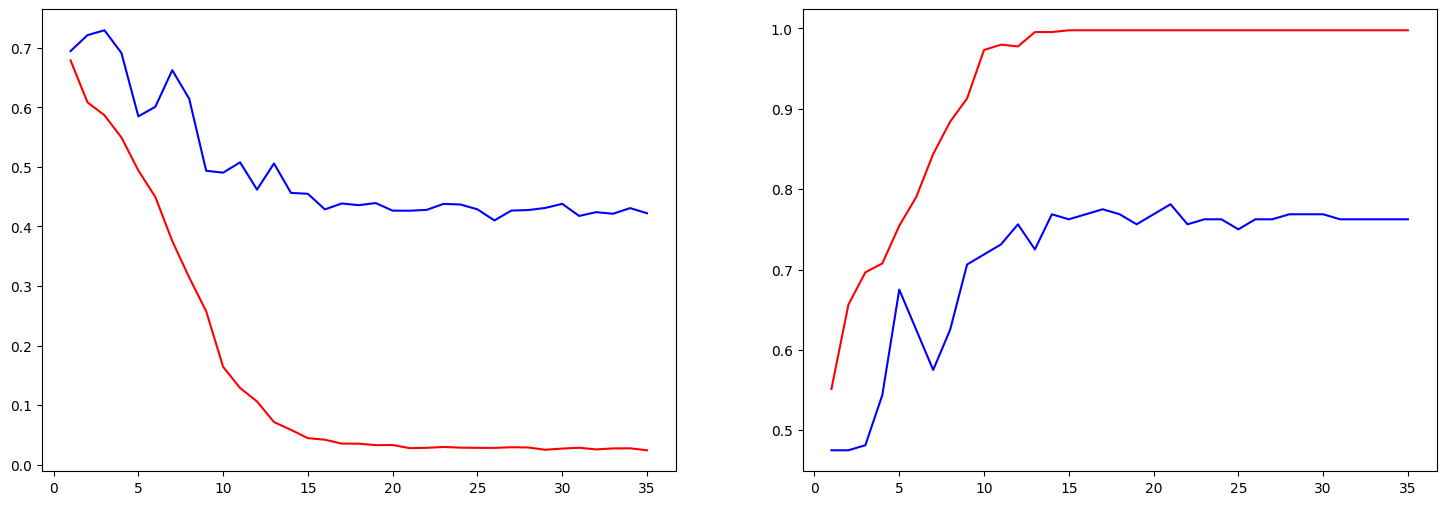

In [26]:
epochs = range(1,len(hist['train_loss'])+1)
fig, ax = plt.subplots(1,2,figsize = (18,6))

ax[0].plot(epochs, trainloss,'r-',label='Train')
ax[0].plot(epochs, valloss,'b-',label='Evaluation')

ax[1].plot(epochs, hist['train_acc'],'r-',label='Train')
ax[1].plot(epochs, hist['val_acc'],'b-',label='Evaluation')

Before Transformation


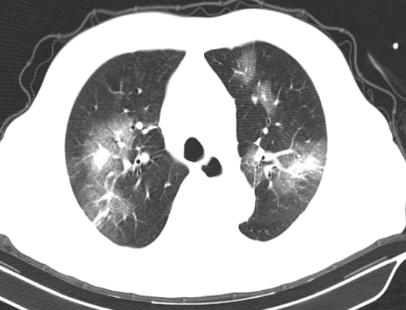

After Trasnformation


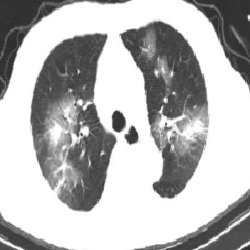

In [28]:
img = PIL.Image.open(images_train[10])
img_trans = transforms.Compose([transforms.Grayscale(),
                                transforms.RandomRotation(5),
                                transforms.Resize((250,250)),
                                transforms.RandomAffine(degrees=0,scale=(1.1,1.1),shear=0.9),
                                transforms.ToTensor()])
trans = img_trans(img)
print("Before Transformation")
display(img)
print("After Trasnformation")
display(transforms.ToPILImage()(trans))

In [35]:
train_dataset_full_aug = CT_Dataset(img_path = images_train,img_labels = y_train,img_transforms = img_trans)
val_dataset = CT_Dataset(img_path = images_val,img_labels = y_val)

In [36]:
cnn_model = Convnet()
history_full_agu = train_model(cnn_model,train_dataset_full_aug,val_dataset,device, lr = 0.001,batch_size = 32,epochs = 35,gamma = 0.75,l2=0.09,patience=5)


Training Start:
LR: 0.001
Epoch: 1 / 35, train_loss:0.71854, train_acc: 0.54911, val_loss:0.70379,valid_acc:0.47500
LR: 0.001
Epoch: 2 / 35, train_loss:0.65240, train_acc: 0.64509, val_loss:0.72040,valid_acc:0.47500
LR: 0.001
Epoch: 3 / 35, train_loss:0.65270, train_acc: 0.61830, val_loss:0.76824,valid_acc:0.47500
LR: 0.001
Epoch: 4 / 35, train_loss:0.65632, train_acc: 0.61830, val_loss:0.70508,valid_acc:0.47500
LR: 0.00075
Epoch: 5 / 35, train_loss:0.68125, train_acc: 0.58036, val_loss:0.69395,valid_acc:0.47500
LR: 0.00075
Epoch: 6 / 35, train_loss:0.63451, train_acc: 0.65848, val_loss:0.67259,valid_acc:0.56875
LR: 0.00075
Epoch: 7 / 35, train_loss:0.62982, train_acc: 0.64286, val_loss:0.65915,valid_acc:0.53125
LR: 0.00075
Epoch: 8 / 35, train_loss:0.63369, train_acc: 0.60938, val_loss:0.68551,valid_acc:0.50000
LR: 0.00075
Epoch: 9 / 35, train_loss:0.66168, train_acc: 0.61830, val_loss:0.69011,valid_acc:0.47500
LR: 0.0005625000000000001
Epoch: 10 / 35, train_loss:0.63562, train_acc: 0

In [37]:
trainloss = [i.detach().cpu().numpy() for i in history_full_agu['train_loss']]
valloss = [i.detach().cpu().numpy() for i in history_full_agu['val_loss']]

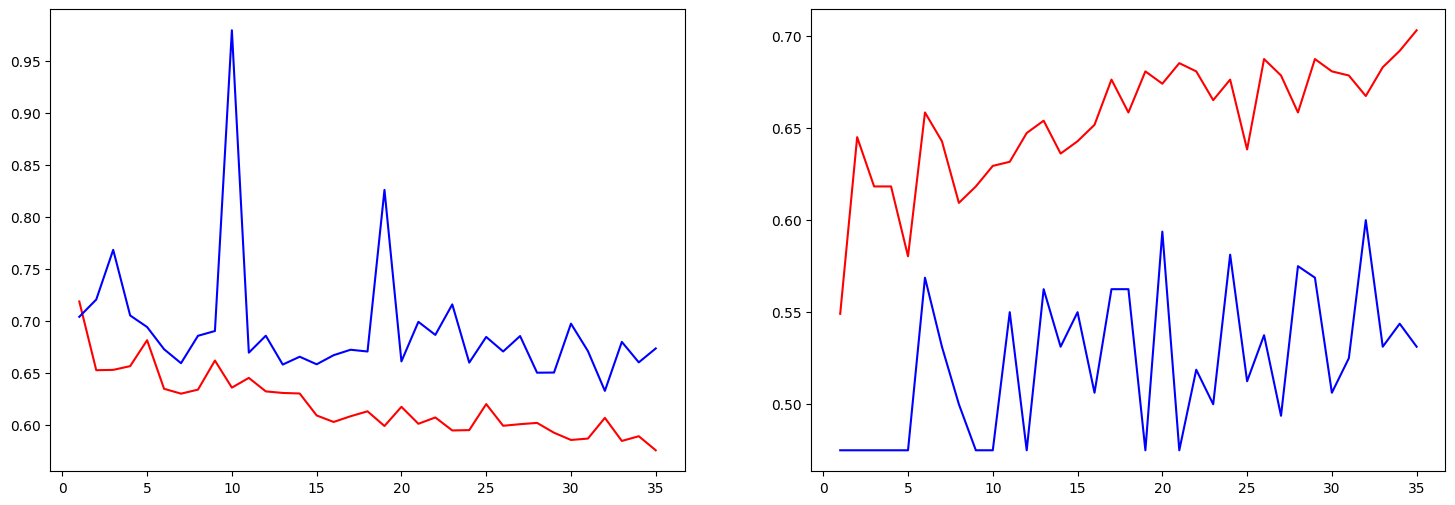

In [39]:
epochs = range(1,len(history_full_agu['train_loss'])+1)
fig, ax = plt.subplots(1,2,figsize = (18,6))

ax[0].plot(epochs, trainloss,'r-',label='Train')
ax[0].plot(epochs, valloss,'b-',label='Evaluation')

ax[1].plot(epochs, history_full_agu['train_acc'],'r-',label='Train')
ax[1].plot(epochs, history_full_agu['val_acc'],'b-',label='Evaluation')

In [52]:
train_dataset_org = CT_Dataset(img_path = images_train,img_labels = y_train)
train_dataset_aug = CT_Dataset(img_path = images_train,img_labels = y_train, img_transforms = img_trans)
train_dataset_total = torch.utils.data.ConcatDataset([train_dataset_org,train_dataset_aug])

val_dataset = CT_Dataset(img_path = images_val,img_labels = y_val)
val_dataset_aug = CT_Dataset(img_path = images_val[:20],img_labels = y_val[:20], img_transforms = img_trans)
val_dataset_total = torch.utils.data.ConcatDataset([val_dataset,val_dataset_aug])

In [53]:
len(train_dataset_total)

894

In [47]:
len(val_dataset_total)

169

In [54]:
cnn_model = Convnet()
history_full_agu = train_model(cnn_model,train_dataset_total,val_dataset_total,device, lr = 0.001,batch_size = 32,epochs = 35,gamma = 0.75,l2=0.09,patience=5)


Training Start:
LR: 0.001
Epoch: 1 / 35, train_loss:0.67940, train_acc: 0.57143, val_loss:0.72004,valid_acc:0.45312
LR: 0.001
Epoch: 2 / 35, train_loss:0.65213, train_acc: 0.63281, val_loss:0.77554,valid_acc:0.44792
LR: 0.001
Epoch: 3 / 35, train_loss:0.65194, train_acc: 0.62165, val_loss:0.74078,valid_acc:0.45312
LR: 0.001
Epoch: 4 / 35, train_loss:0.66610, train_acc: 0.62277, val_loss:0.88187,valid_acc:0.45312
LR: 0.00075
Epoch: 5 / 35, train_loss:0.63404, train_acc: 0.62500, val_loss:0.67547,valid_acc:0.54688
LR: 0.00075
Epoch: 6 / 35, train_loss:0.64216, train_acc: 0.64509, val_loss:0.63744,valid_acc:0.55729
LR: 0.00075
Epoch: 7 / 35, train_loss:0.63970, train_acc: 0.61384, val_loss:0.68418,valid_acc:0.45312
LR: 0.00075
Epoch: 8 / 35, train_loss:0.65093, train_acc: 0.58817, val_loss:0.68040,valid_acc:0.52083
LR: 0.00075
Epoch: 9 / 35, train_loss:0.65365, train_acc: 0.59821, val_loss:0.98143,valid_acc:0.45833
LR: 0.0005625000000000001
Epoch: 10 / 35, train_loss:0.65852, train_acc: 0

In [49]:
trainloss = [i.detach().cpu().numpy() for i in history_full_agu['train_loss']]
valloss = [i.detach().cpu().numpy() for i in history_full_agu['val_loss']]

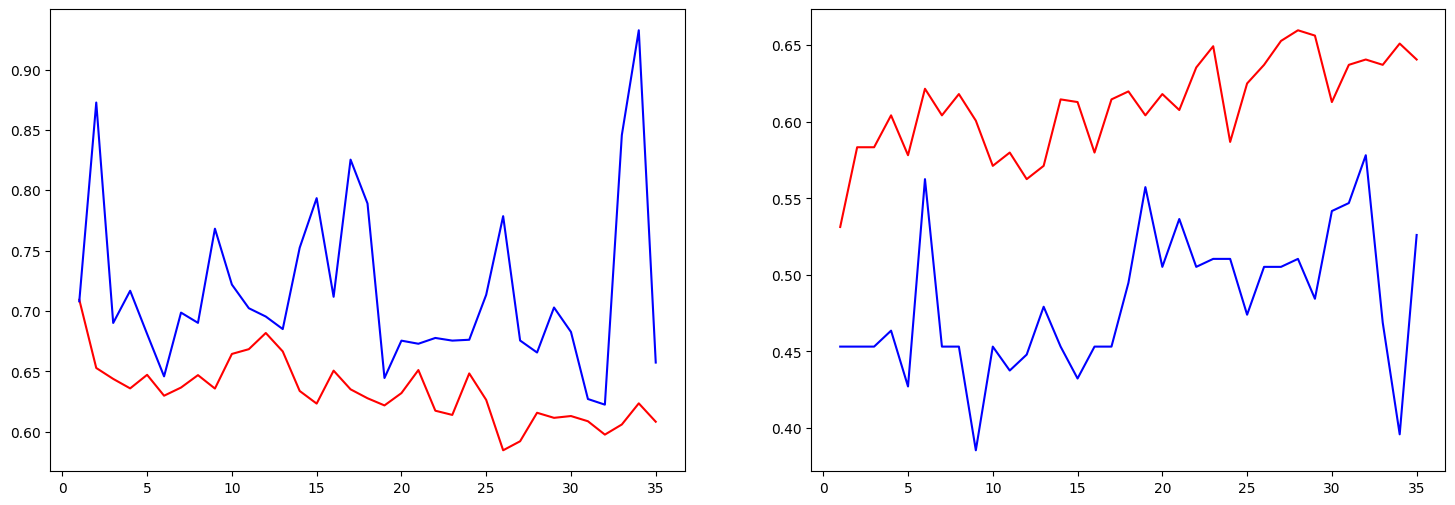

In [51]:
epochs = range(1,len(history_full_agu['train_loss'])+1)
fig, ax = plt.subplots(1,2,figsize = (18,6))

ax[0].plot(epochs, trainloss,'r-',label='Train')
ax[0].plot(epochs, valloss,'b-',label='Evaluation')

ax[1].plot(epochs, history_full_agu['train_acc'],'r-',label='Train')
ax[1].plot(epochs, history_full_agu['val_acc'],'b-',label='Evaluation')